In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, confusion_matrix, 
                           classification_report, roc_curve, auc)
import warnings
warnings.filterwarnings('ignore')

# Set style for visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Load the dataset
df = pd.read_excel('SLU Opportunity Wise Data-1710158595043.xlsx', sheet_name='Original')

print("Dataset Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nFirst few rows:")
print(df.head())

Dataset Shape: (8558, 16)

Columns: ['Learner SignUp DateTime', 'Opportunity Id', 'Opportunity Name', 'Opportunity Category', 'Opportunity End Date', 'First Name', 'Date of Birth', 'Gender', 'Country', 'Institution Name', 'Current/Intended Major', 'Entry created at', 'Status Description', 'Status Code', 'Apply Date', 'Opportunity Start Date']

First few rows:
  Learner SignUp DateTime                  Opportunity Id  \
0     06/14/2023 12:30:35  00000000-0GN2-A0AY-7XK8-C5FZPP   
1     2023-01-05 05:29:16  00000000-0GN2-A0AY-7XK8-C5FZPP   
2     2023-09-04 20:35:08  00000000-0GN2-A0AY-7XK8-C5FZPP   
3     08/29/2023 05:20:03  00000000-0GN2-A0AY-7XK8-C5FZPP   
4     2023-06-01 15:26:36  00000000-0GN2-A0AY-7XK8-C5FZPP   

                                    Opportunity Name Opportunity Category  \
0  Career Essentials: Getting Started with Your P...               Course   
1  Career Essentials: Getting Started with Your P...               Course   
2  Career Essentials: Getting Started wi

In [4]:
# 1. DATA PREPARATION & CHURN DEFINITION
# Define churn based on Status Description
# Assuming: Withdraw = Churn (1), Others = Not Churn (0)
# You can adjust this definition based on business understanding
churn_mapping = {
    'Withdraw': 1,
    'Waitlisted': 1,  # Can be considered as potential churn
    'Started': 0,
    'Team Allocated': 0,
    'Rewards Award': 0
}

df['Churn'] = df['Status Description'].map(churn_mapping)

# Handle any unmapped statuses
if df['Churn'].isnull().any():
    df['Churn'].fillna(0, inplace=True)  # Default to not churn

print(f"\nChurn Distribution:\n{df['Churn'].value_counts()}")
print(f"Churn Rate: {(df['Churn'].sum()/len(df)*100):.2f}%")


Churn Distribution:
Churn
0.0    8363
1.0     195
Name: count, dtype: int64
Churn Rate: 2.28%


In [6]:
# 2. DATA CLEANING & FEATURE ENGINEERING
# Clean column names
df.columns = df.columns.str.strip().str.replace(' ', '_').str.replace('/', '_')

# Handle date columns
date_columns = ['Learner_SignUp_DateTime', 'Opportunity_End_Date', 
                'Date_of_Birth', 'Entry_created_at', 'Apply_Date', 
                'Opportunity_Start_Date']

for col in date_columns:
    if col in df.columns:
        try:
            # Handle mixed date formats
            df[col] = pd.to_datetime(df[col], errors='coerce')
        except:
            # Try different format if needed
            try:
                df[col] = pd.to_datetime(df[col], format='%m/%d/%Y %H:%M:%S', errors='coerce')
            except:
                df[col] = pd.NaT

# Create time-based features
if 'Learner_SignUp_DateTime' in df.columns and 'Apply_Date' in df.columns:
    df['Signup_to_Apply_Days'] = (df['Apply_Date'] - df['Learner_SignUp_DateTime']).dt.days
    df['Signup_Month'] = df['Learner_SignUp_DateTime'].dt.month
    df['Signup_Weekday'] = df['Learner_SignUp_DateTime'].dt.weekday

# Age calculation
if 'Date_of_Birth' in df.columns:
    df['Age'] = (pd.to_datetime('2024-01-01') - df['Date_of_Birth']).dt.days / 365.25
    df['Age_Group'] = pd.cut(df['Age'], bins=[0, 18, 25, 35, 50, 100], 
                            labels=['<18', '18-25', '26-35', '36-50', '50+'])

# Duration features
if 'Opportunity_Start_Date' in df.columns and 'Opportunity_End_Date' in df.columns:
    df['Course_Duration_Days'] = (df['Opportunity_End_Date'] - df['Opportunity_Start_Date']).dt.days

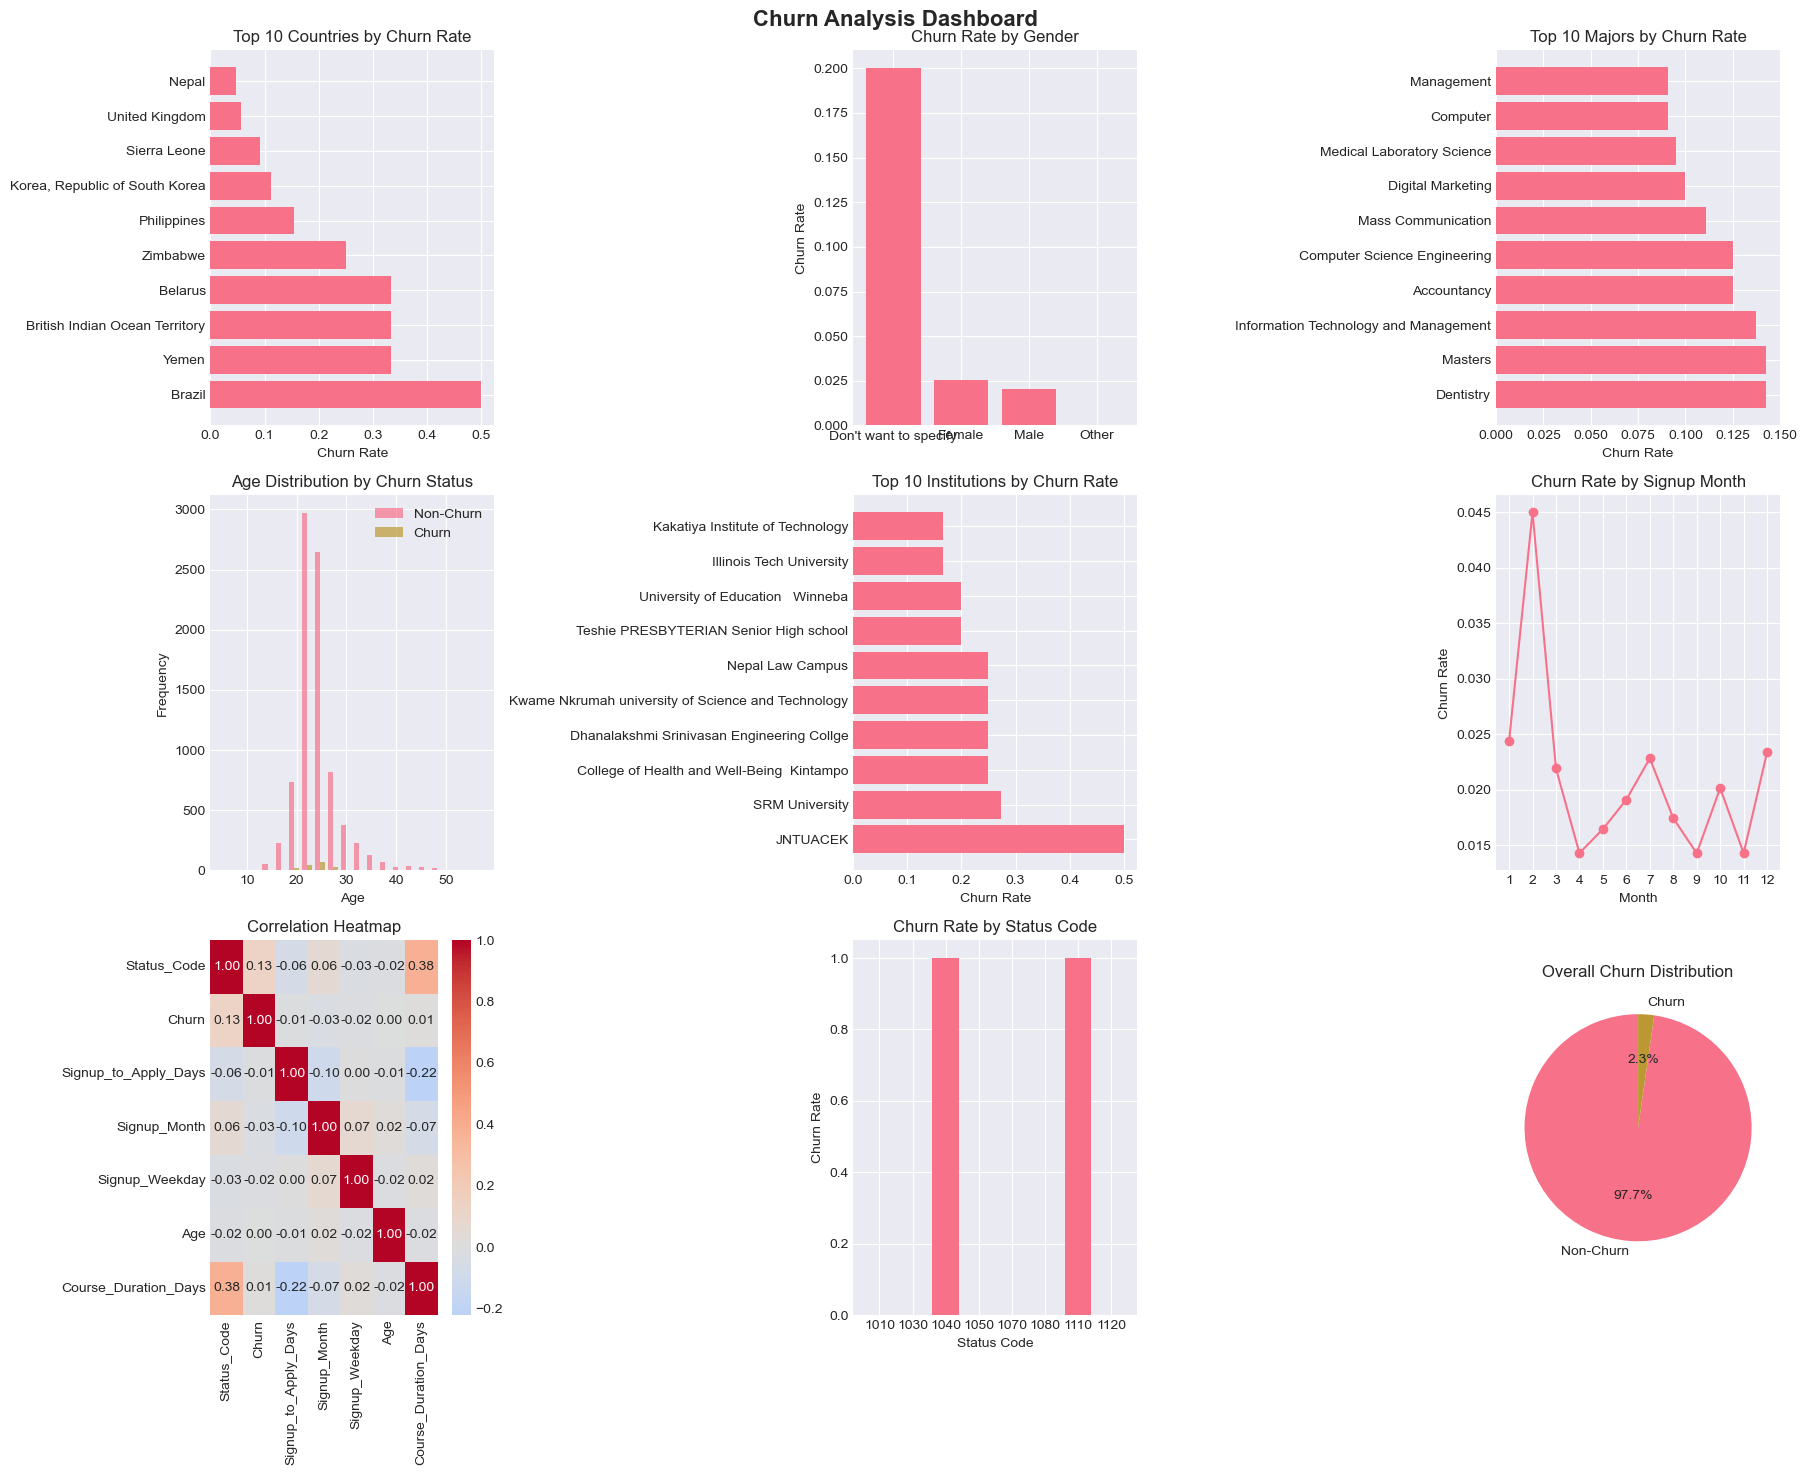

In [8]:
# 3. EXPLORATORY DATA ANALYSIS FOR CHURN

def plot_churn_analysis(df):
    """Visualize churn patterns across different features"""
    
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    fig.suptitle('Churn Analysis Dashboard', fontsize=16, fontweight='bold')
    
    # 1. Churn by Country
    if 'Country' in df.columns:
        churn_by_country = df.groupby('Country')['Churn'].mean().sort_values(ascending=False).head(10)
        axes[0,0].barh(churn_by_country.index, churn_by_country.values)
        axes[0,0].set_title('Top 10 Countries by Churn Rate')
        axes[0,0].set_xlabel('Churn Rate')
    
    # 2. Churn by Gender
    if 'Gender' in df.columns:
        churn_by_gender = df.groupby('Gender')['Churn'].mean()
        axes[0,1].bar(churn_by_gender.index, churn_by_gender.values)
        axes[0,1].set_title('Churn Rate by Gender')
        axes[0,1].set_ylabel('Churn Rate')
    
    # 3. Churn by Major
    if 'Current_Intended_Major' in df.columns:
        major_churn = df.groupby('Current_Intended_Major')['Churn'].agg(['count', 'mean'])
        major_churn = major_churn[major_churn['count'] > 5]  # Filter for majors with sufficient data
        top_majors = major_churn.nlargest(10, 'mean')
        axes[0,2].barh(top_majors.index, top_majors['mean'])
        axes[0,2].set_title('Top 10 Majors by Churn Rate')
        axes[0,2].set_xlabel('Churn Rate')
    
    # 4. Age vs Churn
    if 'Age' in df.columns:
        axes[1,0].hist([df[df['Churn']==0]['Age'].dropna(), 
                       df[df['Churn']==1]['Age'].dropna()], 
                      label=['Non-Churn', 'Churn'], alpha=0.7, bins=20)
        axes[1,0].set_title('Age Distribution by Churn Status')
        axes[1,0].set_xlabel('Age')
        axes[1,0].set_ylabel('Frequency')
        axes[1,0].legend()
    
    # 5. Churn by Institution
    if 'Institution_Name' in df.columns:
        inst_churn = df.groupby('Institution_Name')['Churn'].agg(['count', 'mean'])
        inst_churn = inst_churn[inst_churn['count'] > 3]
        top_inst = inst_churn.nlargest(10, 'mean')
        axes[1,1].barh(top_inst.index, top_inst['mean'])
        axes[1,1].set_title('Top 10 Institutions by Churn Rate')
        axes[1,1].set_xlabel('Churn Rate')
    
    # 6. Churn by Month
    if 'Signup_Month' in df.columns:
        monthly_churn = df.groupby('Signup_Month')['Churn'].mean()
        axes[1,2].plot(monthly_churn.index, monthly_churn.values, marker='o')
        axes[1,2].set_title('Churn Rate by Signup Month')
        axes[1,2].set_xlabel('Month')
        axes[1,2].set_ylabel('Churn Rate')
        axes[1,2].set_xticks(range(1, 13))
    
    # 7. Correlation Heatmap (select numerical features)
    numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
    if len(numerical_features) > 1 and 'Churn' in numerical_features:
        corr_matrix = df[numerical_features].corr()
        sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
                   center=0, ax=axes[2,0])
        axes[2,0].set_title('Correlation Heatmap')
    
    # 8. Churn by Status Code
    if 'Status_Code' in df.columns:
        status_churn = df.groupby('Status_Code')['Churn'].mean()
        axes[2,1].bar(status_churn.index.astype(str), status_churn.values)
        axes[2,1].set_title('Churn Rate by Status Code')
        axes[2,1].set_xlabel('Status Code')
        axes[2,1].set_ylabel('Churn Rate')
    
    # 9. Overall churn distribution
    churn_counts = df['Churn'].value_counts()
    axes[2,2].pie(churn_counts.values, labels=['Non-Churn', 'Churn'], 
                 autopct='%1.1f%%', startangle=90)
    axes[2,2].set_title('Overall Churn Distribution')
    
    plt.tight_layout()
    plt.show()

# Run EDA visualization
plot_churn_analysis(df)


In [10]:
# 4. FEATURE SELECTION & PREPROCESSING

# Select features for modeling
feature_columns = [
    'Gender', 'Country', 'Institution_Name', 'Current_Intended_Major',
    'Age', 'Signup_to_Apply_Days', 'Signup_Month', 'Signup_Weekday',
    'Course_Duration_Days'
]

# Filter available features
available_features = [col for col in feature_columns if col in df.columns]
X = df[available_features].copy()
y = df['Churn'].copy()

print(f"\nAvailable features for modeling: {available_features}")
print(f"Target variable shape: {y.shape}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\nTrain set: {X_train.shape}, Test set: {X_test.shape}")

# Define preprocessing for different feature types
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"\nCategorical features: {categorical_features}")
print(f"Numerical features: {numerical_features}")

# Create preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)



Available features for modeling: ['Gender', 'Country', 'Institution_Name', 'Current_Intended_Major', 'Age', 'Signup_to_Apply_Days', 'Signup_Month', 'Signup_Weekday', 'Course_Duration_Days']
Target variable shape: (8558,)

Train set: (5990, 9), Test set: (2568, 9)

Categorical features: ['Gender', 'Country', 'Institution_Name', 'Current_Intended_Major']
Numerical features: ['Age', 'Signup_to_Apply_Days', 'Signup_Month', 'Signup_Weekday', 'Course_Duration_Days']


In [12]:
# 5. MODEL BUILDING & TRAINING

models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
    'Decision Tree': DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100)
}

# Train and evaluate models
results = {}
feature_importances = {}

for name, model in models.items():
    print(f"\n{'='*60}")
    print(f"Training {name}")
    print('='*60)
    
    # Create pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Train model
    pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Calculate metrics
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1': f1_score(y_test, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    }
    
    # Get feature importances for tree-based models
    if name in ['Decision Tree', 'Random Forest', 'Gradient Boosting']:
        try:
            # Get feature names after one-hot encoding
            if 'cat' in pipeline.named_steps['preprocessor'].transformers_[1][0]:
                ohe = pipeline.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot']
                cat_feature_names = ohe.get_feature_names_out(categorical_features)
                all_feature_names = numerical_features + list(cat_feature_names)
            else:
                all_feature_names = numerical_features + categorical_features
            
            if hasattr(pipeline.named_steps['classifier'], 'feature_importances_'):
                importances = pipeline.named_steps['classifier'].feature_importances_
                feature_importances[name] = pd.DataFrame({
                    'feature': all_feature_names,
                    'importance': importances
                }).sort_values('importance', ascending=False).head(15)
        except Exception as e:
            print(f"Could not extract feature importances for {name}: {e}")
    
    # Print classification report
    print(f"\nClassification Report for {name}:")
    print(classification_report(y_test, y_pred, target_names=['Non-Churn', 'Churn']))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"Confusion Matrix:\n{cm}")


Training Logistic Regression

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

   Non-Churn       0.98      0.83      0.90      2509
       Churn       0.05      0.39      0.09        59

    accuracy                           0.82      2568
   macro avg       0.52      0.61      0.49      2568
weighted avg       0.96      0.82      0.88      2568

Confusion Matrix:
[[2070  439]
 [  36   23]]

Training Decision Tree

Classification Report for Decision Tree:
              precision    recall  f1-score   support

   Non-Churn       0.98      0.97      0.98      2509
       Churn       0.13      0.19      0.15        59

    accuracy                           0.95      2568
   macro avg       0.56      0.58      0.56      2568
weighted avg       0.96      0.95      0.96      2568

Confusion Matrix:
[[2436   73]
 [  48   11]]

Training Random Forest

Classification Report for Random Forest:
              precision    recall  f1-score   


MODEL PERFORMANCE COMPARISON
                     accuracy  precision    recall        f1   roc_auc
Logistic Regression  0.815031   0.049784  0.389831  0.088292  0.607180
Decision Tree        0.952882   0.130952  0.186441  0.153846  0.579156
Random Forest        0.970016   0.200000  0.101695  0.134831  0.677041
Gradient Boosting    0.974688   0.200000  0.033898  0.057971  0.662358


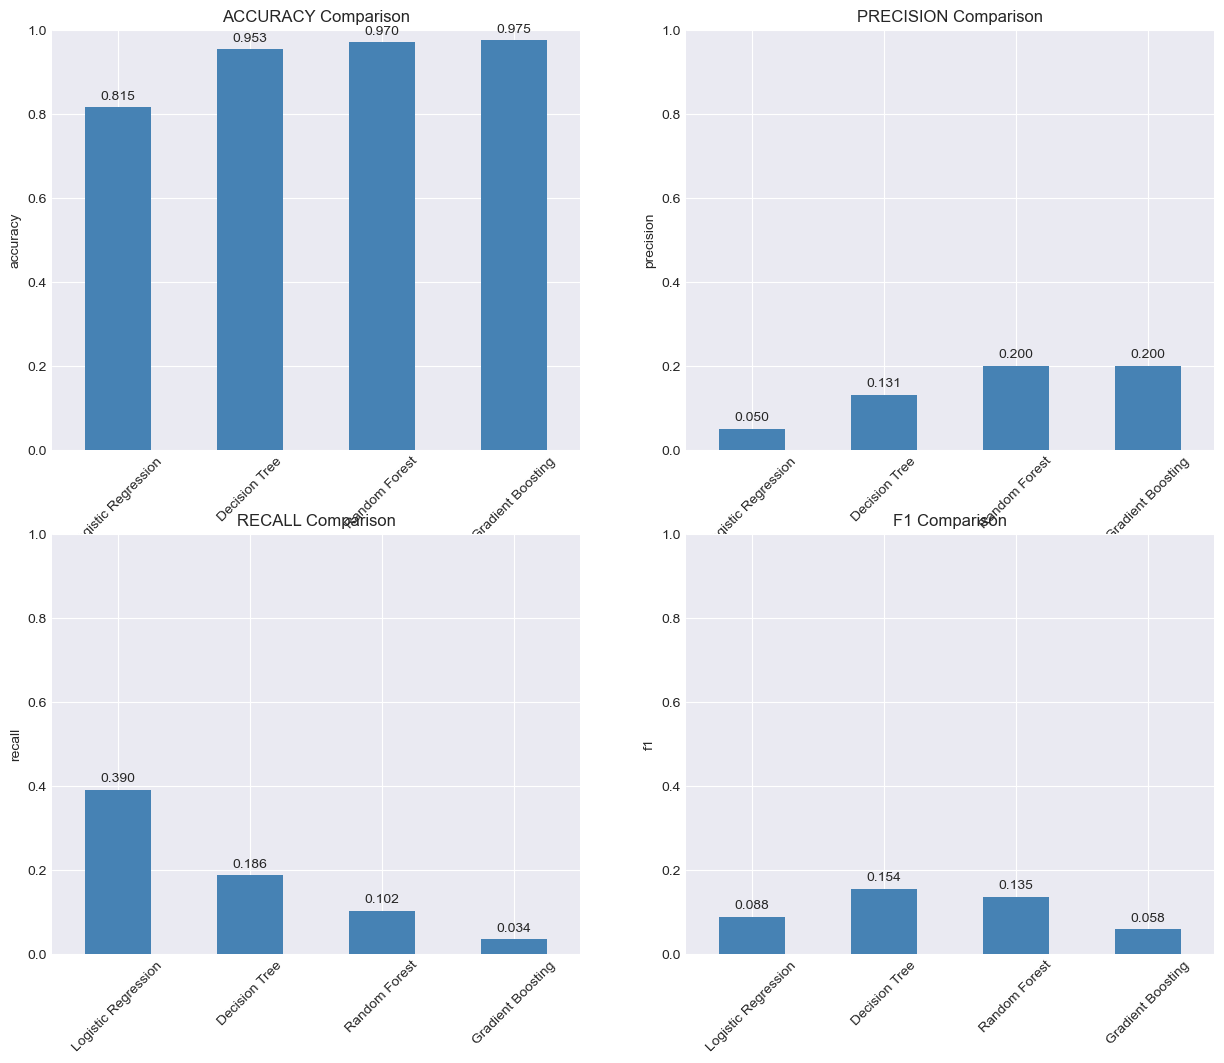

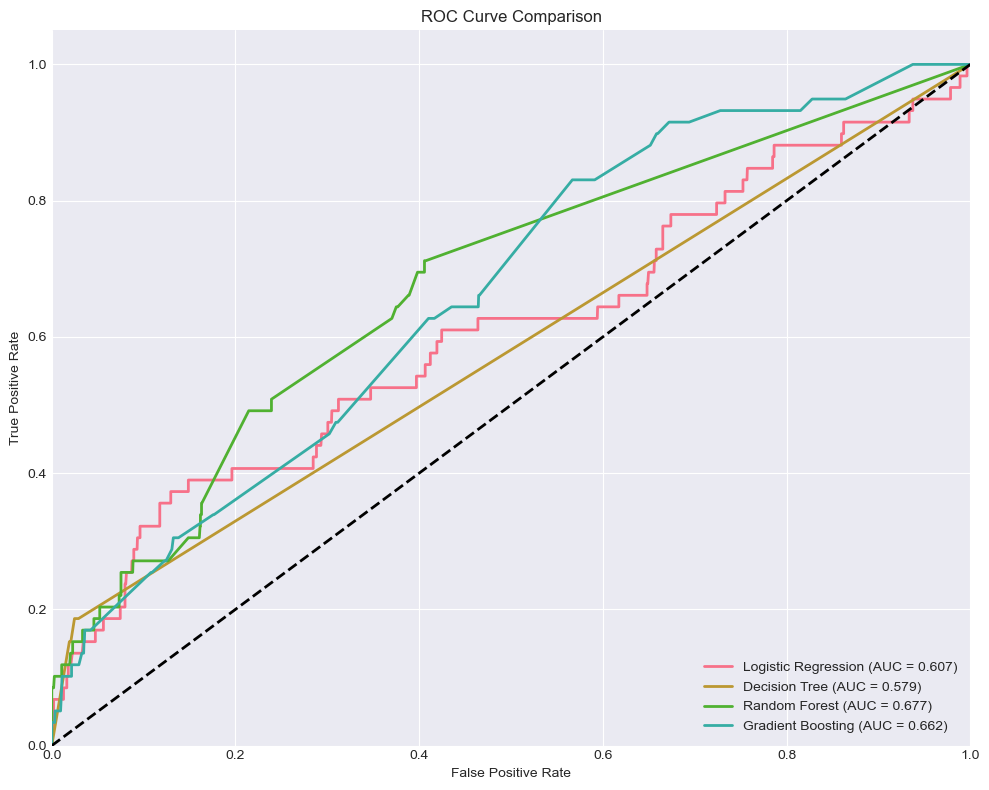

In [13]:
# 6. MODEL COMPARISON & EVALUATION

# Create comparison dataframe
results_df = pd.DataFrame(results).T
print("\n" + "="*60)
print("MODEL PERFORMANCE COMPARISON")
print("="*60)
print(results_df)

# Plot model comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Model metrics comparison
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1']
for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx//2, idx%2]
    results_df[metric].plot(kind='bar', ax=ax, color='steelblue')
    ax.set_title(f'{metric.upper()} Comparison')
    ax.set_ylabel(metric)
    ax.set_xticklabels(results_df.index, rotation=45)
    ax.set_ylim([0, 1])
    
    # Add value labels
    for i, v in enumerate(results_df[metric]):
        ax.text(i, v + 0.02, f'{v:.3f}', ha='center')

# 2. ROC Curve comparison
fig_roc, ax_roc = plt.subplots(figsize=(10, 8))
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    pipeline.fit(X_train, y_train)
    
    if hasattr(model, 'predict_proba'):
        y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        ax_roc.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')

ax_roc.plot([0, 1], [0, 1], 'k--', lw=2)
ax_roc.set_xlim([0.0, 1.0])
ax_roc.set_ylim([0.0, 1.05])
ax_roc.set_xlabel('False Positive Rate')
ax_roc.set_ylabel('True Positive Rate')
ax_roc.set_title('ROC Curve Comparison')
ax_roc.legend(loc="lower right")
ax_roc.grid(True)

plt.tight_layout()
plt.show()

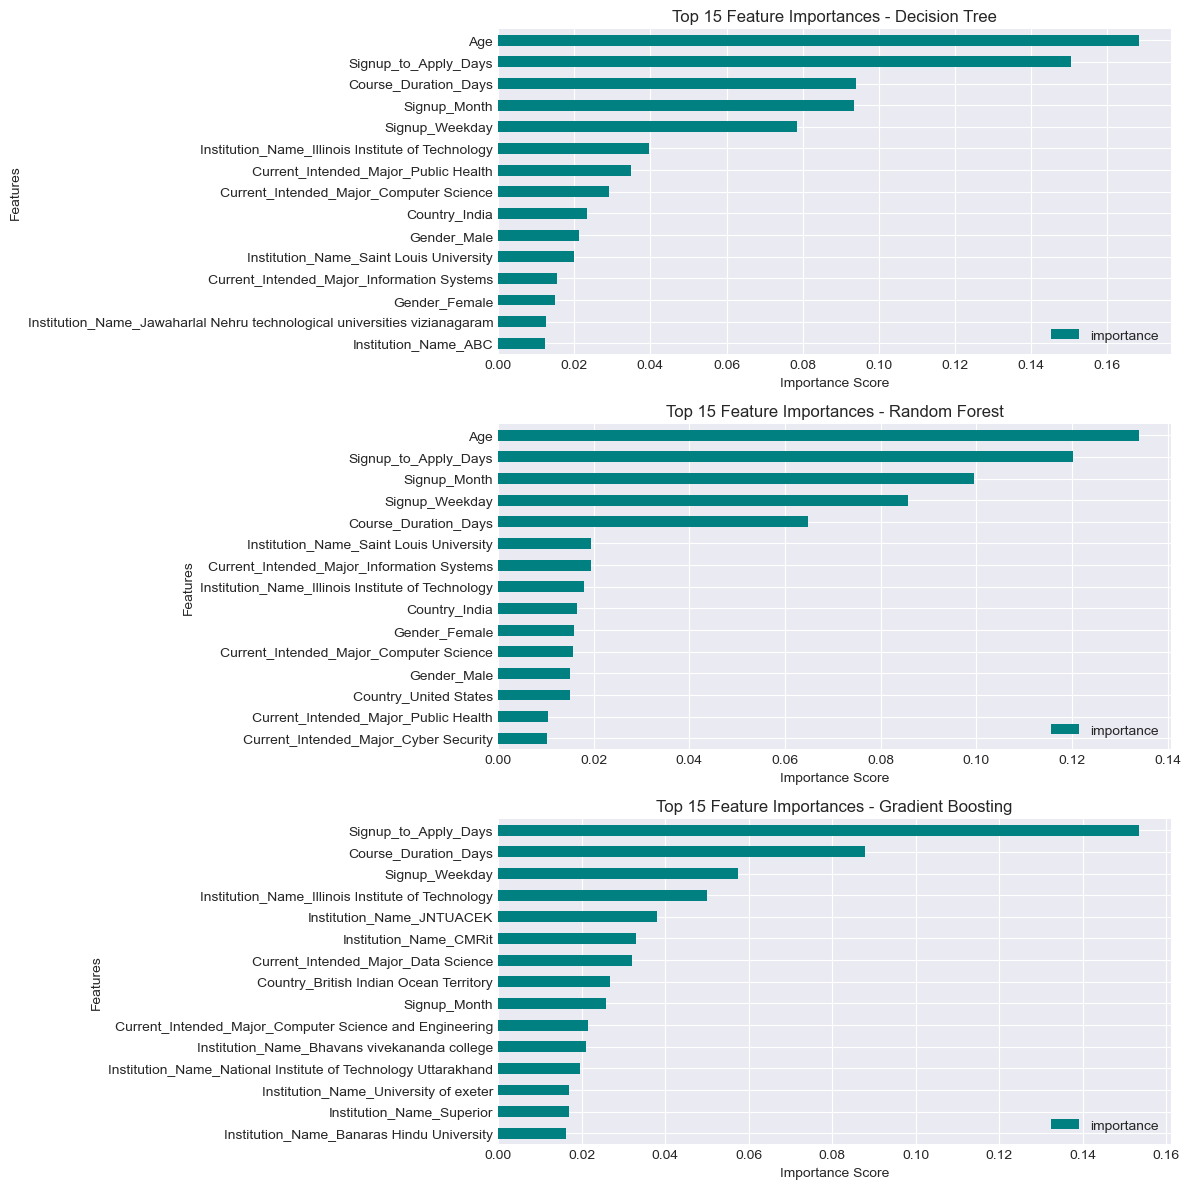

In [15]:
# 7. FEATURE IMPORTANCE ANALYSIS

# Plot feature importances
if feature_importances:
    fig, axes = plt.subplots(len(feature_importances), 1, 
                           figsize=(12, 4*len(feature_importances)))
    
    if len(feature_importances) == 1:
        axes = [axes]
    
    for idx, (model_name, fi_df) in enumerate(feature_importances.items()):
        ax = axes[idx]
        fi_df.sort_values('importance', ascending=True).tail(15).plot(
            kind='barh', x='feature', y='importance', ax=ax, color='teal'
        )
        ax.set_title(f'Top 15 Feature Importances - {model_name}')
        ax.set_xlabel('Importance Score')
        ax.set_ylabel('Features')
    
    plt.tight_layout()
    plt.show()


In [18]:
# 8. BUSINESS INSIGHTS & RECOMMENDATIONS

print("\n" + "="*60)
print("BUSINESS INSIGHTS & RECOMMENDATIONS")
print("="*60)

# Analyze top features affecting churn
if 'Random Forest' in feature_importances:
    top_features = feature_importances['Random Forest'].head(10)
    print("\nTop 10 Factors Influencing Churn:")
    for idx, row in top_features.iterrows():
        print(f"{idx+1}. {row['feature']}: {row['importance']:.3f}")

# Segment analysis for actionable insights
print("\n\n1. HIGH-RISK SEGMENTS IDENTIFICATION:")
print("-"*40)

# Country-wise analysis
if 'Country' in df.columns:
    country_churn = df.groupby('Country').agg({
        'Churn': ['mean', 'count']
    }).round(3)
    country_churn.columns = ['Churn_Rate', 'Student_Count']
    high_risk_countries = country_churn[country_churn['Student_Count'] > 5].nlargest(5, 'Churn_Rate')
    print("\nTop 5 High-Risk Countries:")
    print(high_risk_countries)

# Major-wise analysis
if 'Current_Intended_Major' in df.columns:
    major_churn = df.groupby('Current_Intended_Major').agg({
        'Churn': ['mean', 'count']
    }).round(3)
    major_churn.columns = ['Churn_Rate', 'Student_Count']
    high_risk_majors = major_churn[major_churn['Student_Count'] > 3].nlargest(5, 'Churn_Rate')
    print("\nTop 5 High-Risk Majors:")
    print(high_risk_majors)

# Age group analysis
if 'Age_Group' in df.columns:
    age_churn = df.groupby('Age_Group').agg({
        'Churn': ['mean', 'count']
    }).round(3)
    age_churn.columns = ['Churn_Rate', 'Student_Count']
    print("\nChurn Rate by Age Group:")
    print(age_churn)

print("\n\n2. ACTIONABLE RECOMMENDATIONS:")
print("-"*40)
print("""
1. TARGETED RETENTION PROGRAMS:
   - Focus on high-risk countries identified in the analysis
   - Develop localized engagement strategies for these regions
   - Consider language support or cultural adaptation if needed

2. PERSONALIZED INTERVENTIONS:
   - Create major-specific support programs for high-risk disciplines
   - Develop age-appropriate engagement strategies
   - Implement early warning systems based on predictive scores

3. TIMELY FOLLOW-UP:
   - Reduce time between signup and course start
   - Implement automated check-ins during critical periods
   - Proactively address concerns for waitlisted students

4. ENHANCED SUPPORT SYSTEMS:
   - Strengthen institutional partnerships with high-churn schools
   - Develop peer mentoring programs
   - Provide additional academic support for challenging majors

5. CONTINUOUS MONITORING:
   - Regularly update predictive models with new data
   - Monitor effectiveness of retention initiatives
   - Conduct A/B testing for different intervention strategies
""")


BUSINESS INSIGHTS & RECOMMENDATIONS

Top 10 Factors Influencing Churn:
1. Age: 0.134
2. Signup_to_Apply_Days: 0.120
3. Signup_Month: 0.100
4. Signup_Weekday: 0.086
5. Course_Duration_Days: 0.065
1152. Institution_Name_Saint Louis University: 0.020
1887. Current_Intended_Major_Information Systems: 0.019
590. Institution_Name_Illinois Institute of Technology: 0.018
32. Country_India: 0.017
7. Gender_Female: 0.016


1. HIGH-RISK SEGMENTS IDENTIFICATION:
----------------------------------------

Top 5 High-Risk Countries:
                                Churn_Rate  Student_Count
Country                                                  
Zimbabwe                             0.250              8
Philippines                          0.154             13
Korea, Republic of South Korea       0.111              9
Sierra Leone                         0.091             11
United Kingdom                       0.056             18

Top 5 High-Risk Majors:
                        Churn_Rate  Student_

In [20]:
# 9. PREDICTION ON NEW DATA & DEPLOYMENT READY

# Create final model pipeline with best performing model
best_model_name = results_df['f1'].idxmax()
print(f"\nBest performing model: {best_model_name}")

final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', models[best_model_name])
])

# Train on full data
final_pipeline.fit(X, y)

# Function to make predictions on new data
def predict_churn_risk(new_data, model_pipeline=final_pipeline):
    """
    Predict churn risk for new students
    
    Parameters:
    -----------
    new_data : DataFrame with same features as training data
    model_pipeline : Trained model pipeline
    
    Returns:
    --------
    DataFrame with predictions and probabilities
    """
    predictions = model_pipeline.predict(new_data)
    probabilities = model_pipeline.predict_proba(new_data)[:, 1]
    
    result_df = new_data.copy()
    result_df['Churn_Prediction'] = predictions
    result_df['Churn_Probability'] = probabilities
    result_df['Risk_Level'] = pd.cut(probabilities, 
                                     bins=[0, 0.3, 0.7, 1.0],
                                     labels=['Low', 'Medium', 'High'])
    
    return result_df

# Example: Predict on a sample of new data
print("\n" + "="*60)
print("PREDICTION EXAMPLE")
print("="*60)

# Create sample new data (in practice, this would be real new data)
sample_new_data = X_test.head(5).copy()
predictions = predict_churn_risk(sample_new_data)
print("\nSample Predictions:")
print(predictions[['Churn_Prediction', 'Churn_Probability', 'Risk_Level']])



Best performing model: Decision Tree

PREDICTION EXAMPLE

Sample Predictions:
      Churn_Prediction  Churn_Probability Risk_Level
3127               0.0                0.0        NaN
931                0.0                0.0        NaN
5467               0.0                0.0        NaN
5430               0.0                0.0        NaN
7093               0.0                0.0        NaN


In [22]:
# 10. MODEL PERSISTENCE (FOR DEPLOYMENT)

import joblib
import json

# Save the model
model_filename = 'churn_prediction_model.pkl'
joblib.dump(final_pipeline, model_filename)
print(f"\nModel saved as {model_filename}")

# Save feature names and preprocessing information
model_metadata = {
    'features': available_features,
    'categorical_features': categorical_features,
    'numerical_features': numerical_features,
    'best_model': best_model_name,
    'model_performance': results_df.loc[best_model_name].to_dict(),
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'churn_rate': float(df['Churn'].mean())
}

with open('model_metadata.json', 'w') as f:
    json.dump(model_metadata, f, indent=4)

print("Model metadata saved as model_metadata.json")

print("\n" + "="*60)
print("ANALYSIS COMPLETE")
print("="*60)


Model saved as churn_prediction_model.pkl
Model metadata saved as model_metadata.json

ANALYSIS COMPLETE
